# 03 Decision trees and Random Forests

## Perform the following tasks

### Using the OverFeat features:


#### For the decision tree classifier:

- Tune its depth using grid search (without cross-validation) and plot the validation curve.
- Split the train set into a (smaller) train and validation sets with respectively 3,200 and 800 samples.
- For each depth (try at least 10 different values), fit the decision tree on the train set and save its train/validation accuracy.
- Create a plot of the depth and accuracy values with one curve for the training scores and one for the validation scores.
- Write your observations in a markdown cell.

#### For the random forest classifier:

- Try different sizes of ensemble, e.g., 50, 100 and 200 trees.
- Fit the random forests on the train set and evaluate them on the validation one.
- Collect the results in a DataFrame.


#### For both:

- Fit your tuned estimators on the entire train set with 4,000 data points and evaluate them on the test set. Print the accuracy values.
- You might want to use PCA as a preprocessing step before your decision tree or random forest estimators to improve the results, e.g., speed or accuracy. In any case, justify your choice in a comment or a markdown cell.



## Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load the data form the .npz
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
# Overview of the data content    
print('Data keys {}'.format(cifar4.keys()))

Data keys dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [3]:
# Generate the features matrices with pixels and overfeat
# Create X/y arrays
Xo = cifar4['overfeat']
Xp = cifar4['pixels']
y = cifar4['labels']
names = cifar4['names']

# Explore data verify the dtype of Xo to be float32
inside = npz_file.files
for c in inside:
        print('\n',str(c)+' shape: '+str(cifar4[c].shape),
              '\n',str(c)+' dtype: '+str(cifar4[c].dtype))


 pixels shape: (5000, 3072) 
 pixels dtype: uint8

 overfeat shape: (5000, 4096) 
 overfeat dtype: float32

 labels shape: (5000,) 
 labels dtype: int64

 names shape: (4,) 
 names dtype: <U8

 allow_pickle shape: () 
 allow_pickle dtype: bool


One can check there are no categorical features as only numerical dtypes are in the list.

In [4]:
# Partition data set to be able to assess model performance and over/under fitting issues
from sklearn.model_selection import train_test_split

# Split data into train/test sets and insure balanced data sets (stratify)
Xo_train, Xo_test, y_train, y_test = train_test_split(Xo, y, train_size=4000, test_size=1000,
    random_state=0, stratify=y)
#print ('Size of Xo_train, y_train :', Xo_train.shape, y_train.shape)
#print ('Size of Xo_test, y_test :', Xo_test.shape, y_test.shape)

# Split data into train/validation sets and insure balanced data sets (stratify)
Xo_tr, Xo_valid, y_tr, y_valid = train_test_split(Xo_train, y_train, train_size=3200, test_size=800,
    random_state=0, stratify=y_train) # select y_train for the second Split
#print ('Size of Xo_tr, y_tr:', Xo_tr.shape, y_tr.shape)
#print ('Size of Xo_valid, y_valid:', Xo_valid.shape, y_valid.shape)

## Decision Tree Classifier

Our data set has a lot of features. It means the decision tree could be very deep and then tend to overfit (high variance)
To prevent this one will use a PCA as preprocessing step to reduce dimentionality and then the number of features.

In [21]:
# Create a Decision tree classifier
# Create a pipeline with a scaler & PCA steps to be assessed if better with or not


# From data exploration stage one knows that with 162 and 387 first components 90-95%
# of variance is explained, then one can take the mean ~275
# Create a PCA object
n_compo = 160 # adjusted to 160 after the grid search
pca = PCA(n_compo) 

pipe = Pipeline([
    ('scaler', StandardScaler()), # small improvment
    ('pca', pca),
    ('tree', DecisionTreeClassifier())
])

### Grid search

In [6]:
# Define a set of reasonable values for each parameter
#n_compo = np.arange(160, 260,25) # 160, 185, .., 260
n_depths = np.arange(1, 16)
#criterion = ['gini','entropy']

# Define the grid of parameters and values to assess
grid = ParameterGrid({
    #'pca__n_components': n_compo,
    'tree__max_depth': n_depths,
    #'tree__criterion': criterion, # disabled to match exercise request
   })

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 15


### Fit & tune parameters / hyperparameters

In [7]:
# Save accuracy on test set
tree_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
    i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a tree classifier
    pipe.fit(Xo_tr, y_tr) # fit on the small train set to tune parameters

    # Save accuracy on train & validation set
    params_dict['accuracy tr'] = pipe.score(Xo_tr, y_tr) # assess with the small train to tune parameter hyperparameters
    tree_scores.append(params_dict)# Save result and corresponding configuration
    params_dict['accuracy valid'] = pipe.score(Xo_valid, y_valid) # assess with validation to tune parameter hyperparameters
    tree_scores.append(params_dict)# Save result and corresponding configuration

print('done!')

Combination 1/15
Combination 2/15
Combination 3/15
Combination 4/15
Combination 5/15
Combination 6/15
Combination 7/15
Combination 8/15
Combination 9/15
Combination 10/15
Combination 11/15
Combination 12/15
Combination 13/15
Combination 14/15
Combination 15/15
done!


### Score dataframe & best results

In [8]:
# Create a Dataframe to gather socres and configuration
df_tree_scores = pd.DataFrame(tree_scores)
df_tree_scores.sort_values(by='accuracy valid', ascending=False).head(10)

,accuracy tr,accuracy valid,tree__max_depth
8,0.717500,0.67250,5
9,0.717500,0.67250,5
10,0.755938,0.65750,6
11,0.755938,0.65750,6
6,0.672813,0.65250,4
7,0.672813,0.65250,4
13,0.801875,0.64875,7
12,0.801875,0.64875,7
17,0.902500,0.63875,9
16,0.902500,0.63875,9


In [9]:
# Print out the best configuration and score on validation set 
tree_idx = df_tree_scores['accuracy valid'].idxmax()
print ('Top accuracy on validation set: {:.3f} with a depth:{}.'
       .format(df_tree_scores.loc[tree_idx,'accuracy valid'], df_tree_scores.loc[tree_idx,'tree__max_depth']))
#print ('Top accuracy on validation set with {} PCA components.'
#       .format(df_tree_scores.loc[idx,'pca__n_components']))

# Print out the best configuration and score on validation set 
tree_idx2 = df_tree_scores['accuracy tr'].idxmax()
print ('Top accuracy on small train set: {:.3f} with a depth:{}.'
       .format(df_tree_scores.loc[tree_idx2,'accuracy tr'], df_tree_scores.loc[tree_idx2,'tree__max_depth']))

Top accuracy on validation set: 0.672 with a depth:5.
Top accuracy on small train set: 0.992 with a depth:15.


### Plot training and validation accuracy curves

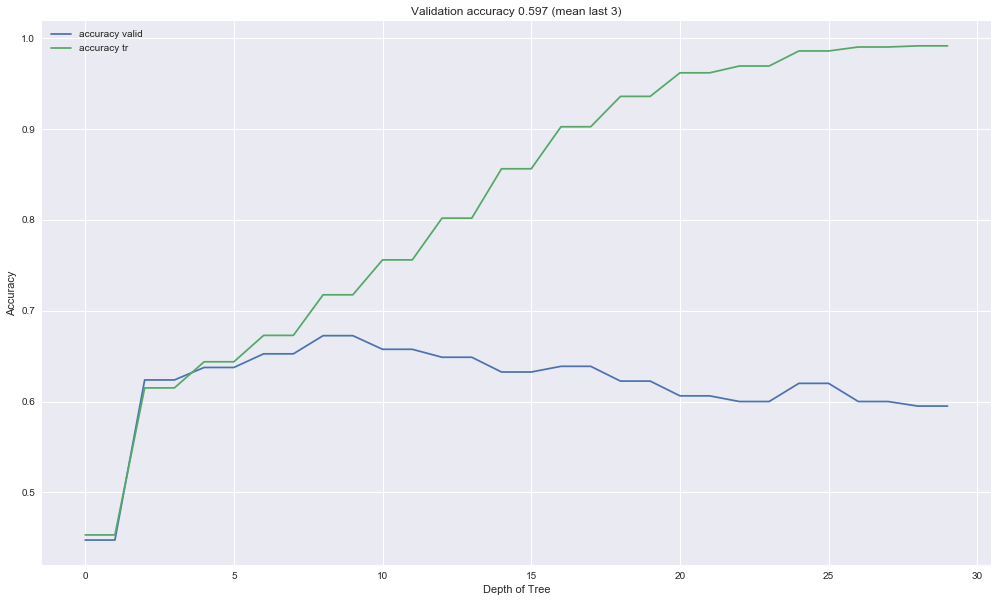

In [10]:
sns.set()
fig = plt.figure(figsize=(17, 10))
# Plot training curves
plt.plot(df_tree_scores['accuracy valid'], label='accuracy valid')
plt.plot(df_tree_scores['accuracy tr'], label='accuracy tr')
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(df_tree_scores['accuracy valid'][-3:]) # last three values
))
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comments on Decision tree classifier

- One saws on the curves that after 3, the two curves start diverging.
- After 8, validation curve starts decreasing.
- The scaling preprocessing step gives a small improvment

## Random Forest Classifier

Our data set has a lot of features. It means the decision tree could be very deep and then tend to overfit (high variance). A Random Forest Classifier is more robust to it because of the bagging technic (ensemble method), we try to reduce the variance of an estimator by averaging the predictions.

Thus one will not use a PCA as preprocessing step to reduce dimentionality and then the number of features.

In [11]:
# Create a Random forest classifier
# Create a pipeline with a scaler step to be assessed if better with or not
pipe = Pipeline([
    #('scaler', StandardScaler()), # does not bring any improvment
    ('Rforest', RandomForestClassifier(n_jobs=-1, random_state=0))
])

### Grid search

In [12]:
# Define the grid of parameters and values to assess
from sklearn.model_selection import ParameterGrid

# Define a set of reasonable values for each parameter
n_estim = np.arange(1050, 1150,25)

# Define a grid of values
grid = ParameterGrid({'Rforest__n_estimators': n_estim})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 4


### Fit & tune parameters / hyperparameters

In [13]:
# Save accuracy on test set
Rforest_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
    i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a tree classifier
    pipe.fit(Xo_tr, y_tr) # fit on the small train set to tune parameters

    # Save accuracy on train & validation set
    params_dict['accuracy tr'] = pipe.score(Xo_tr, y_tr) # assess with the small train to tune parameter hyperparameters
    Rforest_scores.append(params_dict)# Save result and corresponding configuration
    params_dict['accuracy valid'] = pipe.score(Xo_valid, y_valid) # assess with validation to tune parameter hyperparameters
    Rforest_scores.append(params_dict)# Save result and corresponding configuration

print('done!')

Combination 1/4
Combination 2/4
Combination 3/4
Combination 4/4
done!


### Score dataframe & best results

In [14]:
# Create a Dataframe to gather socres and configuration
df_Rforest_scores = pd.DataFrame(Rforest_scores)
df_Rforest_scores.sort_values(by='accuracy valid', ascending=False).head(10)

,Rforest__n_estimators,accuracy tr,accuracy valid
2,1075,1.0,0.79875
3,1075,1.0,0.79875
0,1050,1.0,0.79625
1,1050,1.0,0.79625
4,1100,1.0,0.79375
5,1100,1.0,0.79375
6,1125,1.0,0.79375
7,1125,1.0,0.79375


In [15]:
# Print out the best configuration and score on validation set 
Rf_idx = df_Rforest_scores['accuracy valid'].idxmax()
print ('Top accuracy on validation set: {:.4f} with a number of estimator:{}.'
       .format(df_Rforest_scores.loc[Rf_idx,'accuracy valid'], df_Rforest_scores.loc[Rf_idx,'Rforest__n_estimators']))

# Print out the best configuration and score on validation set 
Rf_idx2 = df_Rforest_scores['accuracy tr'].idxmax()
print ('Top accuracy on small train set: {:.3f} with a number of estimator:{}.'
       .format(df_Rforest_scores.loc[Rf_idx2,'accuracy tr'], df_Rforest_scores.loc[Rf_idx2,'Rforest__n_estimators']))

Top accuracy on validation set: 0.7987 with a number of estimator:1075.
Top accuracy on small train set: 1.000 with a number of estimator:1050.


### Comments on Random forest classifier
- How do we juge overfitting with a Random Forest Classifier ?
- It seems the train accuracy is over 1 very early in the number of estimator.

# Tuned Models with full train set

In [19]:
# Tuned Decision tree
tree_tuned = DecisionTreeClassifier(max_depth= df_tree_scores.loc[tree_idx,'tree__max_depth'])
pca_tuned = PCA(n_compo)
pipe = Pipeline([('pca', pca_tuned),('tree', tree_tuned)])
pipe.fit(Xo_train, y_train)
tree_tuned_acc = pipe.score(Xo_test, y_test)
print ('Decision tree accuracy (test set): {:.4f}'.format(tree_tuned_acc))

Decision tree accuracy (test set): 0.6440


In [17]:
# Tuned Random forest
Rforest_tuned = RandomForestClassifier(n_estimators = df_Rforest_scores.loc[Rf_idx,'Rforest__n_estimators'], n_jobs=-1)
pipe = Pipeline([('pca', None),('tree', Rforest_tuned)])
pipe.fit(Xo_train, y_train)
Rforest_tuned_acc = pipe.score(Xo_test, y_test)
print ('Random forest accuracy (test set): {:.4f}'.format(Rforest_tuned_acc))

Random forest accuracy (test set): 0.7960
